## Image Stiching

In [11]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline
#%matplotlib 

import numpy as np
import cv2 as cv
print(f'Version de OpenCV: {cv.__version__}')
import matplotlib.pyplot as plt

Version de OpenCV: 3.4.2


En este ejemplo vamos a generar una vista panoramica a partir de 2 imagenes. La unica condicion es que las imagenes a utilizar presenten un solapamiento parcial para poder encontrar puntos en comun dentro de la escena.

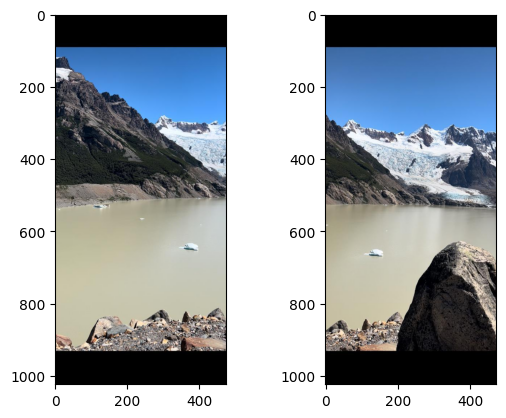

In [12]:
# Cargamos la imagen a procesar
img_left = cv.imread('imagenes/pano_1.jpg')
img_right = cv.imread('imagenes/pano_2.jpg')

# La transformamos en escala de grises
gray_left = cv.cvtColor(img_left, cv.COLOR_BGR2GRAY)
gray_right = cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)
img_left = cv.cvtColor(img_left, cv.COLOR_BGR2RGB)
img_right = cv.cvtColor(img_right, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_left)
plt.subplot(1,2,2)
plt.imshow(img_right)

#### 1. Obtenemos los descriptores

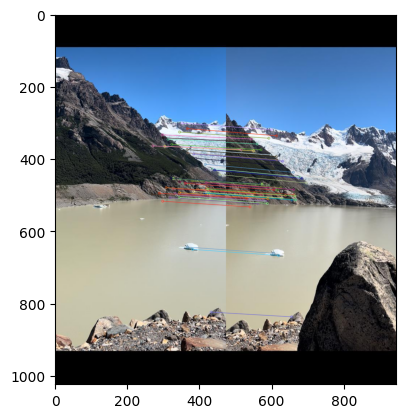

In [13]:
# Creamos el vector de características SIFT
sift = cv.xfeatures2d.SIFT_create()

# Y buscamos según el algoritmo...
kps_left, descriptors_left = sift.detectAndCompute(gray_left, None)
kps_right, descriptors_right = sift.detectAndCompute(gray_right, None)

# me quedo solo con valores x,y de la posicion de los descriptores
kps_loc_left = np.float32([kp.pt for kp in kps_left])
kps_loc_right = np.float32([kp.pt for kp in kps_right])

# BFMatcher con parámetros por defecto
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
matches = bf.match(descriptors_left, descriptors_right)

# Los ordenamos según distancia
matches = sorted(matches, key = lambda x:x.distance)

# Dibujamos las primeras 50 coincidencias
n=50
img_matched = cv.drawMatches(img_left, kps_left, img_right, kps_right, matches[:n], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure()
plt.imshow(img_matched)

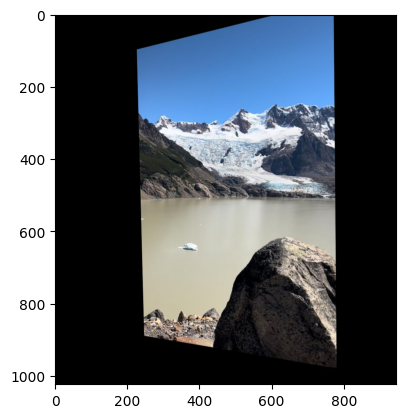

In [14]:
if len(matches) > 4:
    # separo las coordenadas de los keypoints que fueron matcheados
    ptsA = np.float32([kps_loc_left[m.queryIdx] for m in matches])
    ptsB = np.float32([kps_loc_right[m.trainIdx] for m in matches])
    
    # Calculamos la matriz de homografia
    (H, status) = cv.findHomography(ptsB, ptsA, cv.RANSAC, 4.0)
    
    result = cv.warpPerspective(img_right, H,(img_left.shape[1] + img_right.shape[1], img_right.shape[0]))
    #result[0:img_left.shape[0], 0:img_right.shape[1]] = img_left
    # mostramos la imagen
    plt.figure()
    plt.imshow(result)
    # plt.imshow(result[100:-100,:-100,:])

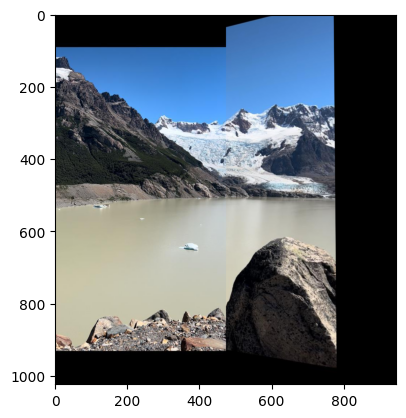

In [15]:
result[0:img_left.shape[0], 0:img_right.shape[1]] = img_left
# mostramos la imagen
plt.figure()
plt.imshow(result)

Metemos todo en una funcion

In [5]:
def frame_stiching(img_left, img_right) -> np.ndarray:
    '''
    Image stiching between 2 BGR frames using SIFT descriptor and brute force
    keypoints matching. 

    Receive
    ------------------------
    img_left:  BGR image, numpy ndarray like
    img_right:  BGR image, numpy ndarray like

    Returns
    -------------------------
    result: BGR image, numpy ndarray like or None if no matches were found
    '''
    gray_left = cv.cvtColor(img_left, cv.COLOR_BGR2GRAY)
    gray_right = cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)
    
    sift = cv.xfeatures2d.SIFT_create()
    kps_left, descriptors_left = sift.detectAndCompute(gray_left, None)
    kps_right, descriptors_right = sift.detectAndCompute(gray_right, None)

    kps_loc_left = np.float32([kp.pt for kp in kps_left])
    kps_loc_right = np.float32([kp.pt for kp in kps_right])
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors_left, descriptors_right)
    matches = sorted(matches, key = lambda x:x.distance)

    if len(matches) > 4:

        ptsA = np.float32([kps_loc_left[m.queryIdx] for m in matches])
        ptsB = np.float32([kps_loc_right[m.trainIdx] for m in matches])

        (H, status) = cv.findHomography(ptsB, ptsA, cv.RANSAC, 4.0)

        result = cv.warpPerspective(img_right, H,(img_left.shape[1] + img_right.shape[1], img_right.shape[0]))
        result[0:img_left.shape[0], 0:img_right.shape[1]] = img_left
        return result
    else:
        return None
    